# Patient Readmission Exploration
#### Author: Izzy Valdivia

### Project Background:
&nbsp;&nbsp;&nbsp;&nbsp; Patient readmission is a powerful indicator of quality of care across the healthcare industry. Readmission is when a person is admitted to the hospital within 30 days of a previous discharge because there was some aspect of their care that was not handled or their condition is worsening. Health care providers and insurers frequently track patient readmission rates from hospital systems to better understand the quality of care provided at those facilities and how that affects patient outcomes. Understanding which hospitals have high readmission rates can help policymakers and insurers launch targeted improvement programs or understand what areas may need more resources. Definitive Healthcare, an analytics company focused on reporting on healthcare metrics in the United States, reports that the average hosiptal readmission rate is ~14.7%, with a range from 10.1 to 19.1% ([Definitive Healthcare, 2025](https://www.definitivehc.com/resourcesz/healthcare-insights/average-hospital-readmission-state#:~:text=What%20is%20the%20average%20hospital,to%2019.1%25%20in%20the%20U.S.)).  
&nbsp;&nbsp;&nbsp;&nbsp; With this context in mind, I am interested in creating a model to predict hospital readmission rates based on quality of care metrics for the Medicare population. I hope to understand what facets of quality of care most impact patient readmission rate for medicare patients. To do this I would most likely perform a regression analysis of readmission rate for each hospital/care system and their corresponding care metrics. Understanding the relationships between patient readmission and quality of care could also help policymakers adjust provider and insurer incentive structures to prioritize the health of individuals.

### Related Work:
&nbsp;&nbsp;&nbsp;&nbsp; There has been some research done about hospital readmission rate that is tangential to the analysis I am aiming to complete. A paper published in 2020 found that looking at a specific subset of care quality measures, specifically patient satisfaction, leads to lower readmissions rates [(Chen et al., 2020)](https://doi.org/10.1108/IJHCQA-03-2019-0066). Similarly, the Agency for Healthcare Research and Quality came out with a Re-Engineered Discharge toolkit that predicts a hospital’s readmission rate based on their member mix. While both of these resources analyze how certain healthcare factors affect a hospital’s readmission rate, I would like to examine this issue with a more comprehensive view. This project will be a multi-faceted approach to examining readmission rates using both clinical factors like timeliness while also incorporating structural aspects such as hospital funding sources and the type of hospital.

### Research Questions:
In order to explore the relationship between hospital quality of care metrics and their patients’ corresponding readmissions rates, I will base my analysis on the following questions: 
* What are the current patterns and distributions of patient readmission rates across the Medicare hospitals and how do they vary by hospital ownership type or location? 
* What quality of care metrics, like timeliness, patient experience, and emergency room wait times are most strongly associated with readmission rate?
* How well do multivariate linear regression and random forest models predict hospital readmission rates using available quality-of-care metrics and structural hospital characteristics?


### Data Sources:
&nbsp;&nbsp;&nbsp;&nbsp;All data collected for this project came [data.cms.gov](data.cms.gov). First of which is the [Hospital General Information dataset](https://data.cms.gov/provider-data/dataset/xubh-q36u#overview) which contains information on all hospitals that have registered with Medicare. Some of the information in this dataset includes address, type of hospital, ownership type (i.e. non-profit, government) and overall rating. Next I will be using the [Hospital Readmissions Reduction Program (HRRP)](https://data.cms.gov/provider-data/dataset/9n3s-kdb3) dataset, which includes information about the number of discharges, number of readmissions, and ratio of readmissions for each facility that is registered with Medicare. The readmission rate would be the outcome variable for the predictive model. Next, I will be using the [Timely and Effective Care](https://data.cms.gov/provider-data/dataset/yv7e-xc69) table that contains information on how hospitals perform on a variety of clinical measures like average time patients wait to be seen in the emergency department and appropriate care rating given to patients with sepsis. These measures are available for each of the hospitals that are registered with Medicare, so the measure ratings could be used as predictors for readmission rate. The license for all of these data sets is not explicitly stated, but according to an FAQ guide for using data from data.cms.gov, “Works of the U.S. Government are in the public domain and you don’t need permission to reuse them, but an attribution to the agency as the source is appreciated.” 

This analysis is being done in November 2025. Data version information is as follows: 

| Table | CSV Name | Last Updated | Release Date | 
| -------- | ------- | ------- | ------- |
| Hospital General Information | Hospital_General_Information.csv | 07-16-2025 | 08-06-2025 |
| Hospital Readmissions Reduction Program | FY_2025_Hospital_Readmission_Reduction_Program_Hospital.csv | 01-08-2025 | 08-06-2025 |
| Timely and Effective Care | Timely_and_Effective_Care-Hospital.csv | 07-24-2025 | 08-06-2025 |

### Methodology:
&nbsp;&nbsp;&nbsp;&nbsp;In order to carry out the investigation outlined in the research questions section of this plan, I will do the following. First, I will do an exploratory analysis of the data and analyze the distribution of readmission rates and ownership types of all registered Medicare hospitals. This will help establish a baseline understanding of the data that can be referenced along with my further analyses. In order to answer the question of whether or not readmission rate varies across ownership types, I will perform an ANOVA test, which will inform whether or not more tests are necessary.  
&nbsp;&nbsp;&nbsp;&nbsp;Next, to answer the second research question about identifying which quality of care metrics are most associated with large readmission rates, I will perform a correlation analysis. This will identify which, if any, of the quality of care metrics are correlated with readmissions and whether or not that correlation is positive or negative. In the case there are many correlated predictor variables I will use LASSO to select only a subset of the most important variables. Important in this context meaning the variables that explain the most variability in the outcome variable.   
&nbsp;&nbsp;&nbsp;&nbsp;Finally, to address the third research question, I will fit a multivariate logistic regression model as well as a random forest model with the quality of care and hospital-specific variables as the predictors. I will compare the R^2, RMSE and MAE values across both model types to evaluate which is the better predictor. Similarly, I will evaluate the models for interpretability. 


In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.linear_model import LassoCV, LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,  mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import textwrap


# HELPER FUNCTIONS:
def check_nulls(df):
    # Calculate null percentage for each column in tec_filtered_wider
    total_rows = df.shape[0]
    print(f"Total rows in tec_filtered_wider: {total_rows}\n")
    print("="*80)
    print(f"{'Column Name':<50} {'Null Count':>12} {'Null %':>10}")
    print("="*80)

    null_percentages = []
    for col in df.columns:
        null_count = df[col].null_count()
        null_pct = (null_count / total_rows) * 100
        null_percentages.append({
            'Column': col,
            'Null_Count': null_count,
            'Null_Percentage': null_pct
        })
        print(f"{col:<50} {null_count:>12} {null_pct:>9.2f}%")

    # Create a summary DataFrame sorted by null percentage
    null_df = pd.DataFrame(null_percentages).sort_values('Null_Percentage', ascending=False)
    print("\n" + "="*80)
    print(f"\nSummary Statistics:")
    print(f"  Columns with 0% null: {(null_df['Null_Percentage'] == 0).sum()}")
    print(f"  Columns with < 10% null: {(null_df['Null_Percentage'] < 10).sum()}")
    print(f"  Columns with 10-50% null: {((null_df['Null_Percentage'] >= 10) & (null_df['Null_Percentage'] < 50)).sum()}")
    print(f"  Columns with >= 50% null: {(null_df['Null_Percentage'] >= 50).sum()}")
    print(f"  Average null percentage: {null_df['Null_Percentage'].mean():.2f}%")
 
def get_dataset_stats(table, name): 
    table_shape = table.shape
    table_rows = table_shape[0]
    table_cols = table_shape[1]

    print(f"The {name} table has has {table_rows} rows and {table_cols} columns")

def create_distribution(data_frame, variable_name, label_name, sorted=False, sorting_col='none', title_flag=False, title="none", rotation=0, bar_color='skyblue'):
    avar = variable_name

    if sorted: 
        grouped_df_counts = data_frame.group_by(avar).agg(
            pl.len().alias(f"{label_name}_count"), 
            pl.col(sorting_col).first().alias("sort_order")
        )
        grouped_df_counts = grouped_df_counts.sort("sort_order")
    else: 
        grouped_df_counts = data_frame.group_by(avar).agg(
            pl.len().alias(f"{label_name}_count"), 
        )
        grouped_df_counts = grouped_df_counts.sort(avar)

    categories = grouped_df_counts[avar]
    category_counts = grouped_df_counts[f"{label_name}_count"]
    
    fig, ax = plt.subplots(figsize=(10, 5)) # Increase figure width
    bars = ax.bar(categories, category_counts)
    ax.bar_label(bars)
    ax.bar(categories, category_counts, color=bar_color)
    ax.set_xlabel(label_name)
    plt.xticks(rotation=rotation)
    plt.gca().set_xticklabels(
    [textwrap.fill(label.get_text(), 12) for label in plt.gca().get_xticklabels()]
)

    ax.set_ylabel(f"{label_name} Count")
    if title_flag:
        plt.title(title)
    else:
        plt.title(f"Distribution of {label_name}")
    plt.show()


def quartile_statistics(df,col): 
    print(df.select(
    pl.col(col).cast(pl.Float64).quantile(0.25).alias(f"Q1 {col}"),
    pl.col(col).cast(pl.Float64).mean().alias(f"Mean {col}"), 
    pl.col(col).cast(pl.Float64).quantile(0.75).alias(f"Q3 {col}")
    ))

def evaluate_model (y_train_reg, y_pred_train_reg, y_test_reg, y_pred_reg): 
    train_mae = mean_absolute_error(y_train_reg,y_pred_train_reg)
    train_mse = mean_squared_error(y_train_reg,y_pred_train_reg)
    train_r_squared = r2_score(y_train_reg,y_pred_train_reg)

    mse = mean_squared_error(y_test_reg, y_pred_reg)
    mae = mean_absolute_error(y_test_reg, y_pred_reg)
    r_squared = r2_score(y_test_reg,y_pred_reg)

    print("TRAINING SET METRICS: ")
    print(f"Train Mean Abs Error: {round(train_mae,4)}")
    print(f"Train Mean Squared Error: {round(train_mse,4)}")
    print(f"Train R^2: {round(train_r_squared,4)}")
    print("="*80)
    print("TEST SET METRICS: ")
    print(f"Test Mean Squared Error: {round(mse,4)}")
    print(f"Test Random Forest Regressor Mean Abs Error: {round(mae,4)}")
    print(f"Test Random Forest Regressor R^2: {round(r_squared,4)}")

| Table | CSV Name | Unique Facility IDs | Num Rows | Num Columns |
| -------- | ------- | ------- | ------- | ------- |
| Hospital General Information | Hospital_General_Information.csv | 5381 | 5381 | 38 |
| Hospital Readmissions Reduction Program | FY_2025_Hospital_Readmission_Reduction_Program_Hospital.csv | 3085 | 18510 | 12 |
| Timely and Effective Care | Timely_and_Effective_Care-Hospital.csv | 4623 | 117933 | 16 |

Load in all 3 of the datasets, and explore the shape of each.

In [80]:
#### Load in Datasets
# Hospital General Information
hgi = pl.read_csv('../data/Hospital_General_Information.csv')
get_dataset_stats(hgi, "hgi")

# Readmission Reduction Program
rrp = pl.read_csv('../data/FY_2025_Hospital_Readmissions_Reduction_Program_Hospital.csv', schema_overrides={'Facility ID': pl.String})
get_dataset_stats(rrp, "RRP")

# Timely and Effective Care
tec = pl.read_csv('../data/Timely_and_Effective_Care-Hospital.csv', schema_overrides={'Facility ID': pl.String})
get_dataset_stats(tec, "tec")


The hgi table has has 5381 rows and 38 columns
The RRP table has has 18510 rows and 12 columns
The tec table has has 117933 rows and 16 columns


In [81]:
facilities_tec = tec['Facility ID'].unique().shape[0]
facilities_hgi = hgi['Facility ID'].unique().shape[0]
facilities_rrp = rrp['Facility ID'].unique().shape[0]

print(f"The number of unique facility IDs in the Timeliness and Effective Care dataset is {facilities_tec}")
print(f"The number of unique facility IDs in Hospital General Information dataset is {facilities_hgi}")
print(f"The number of unique facility IDs in Readmissions Reduction Program dataset is {facilities_rrp}")


# print(f"numrows of tec is {tec_rows}")

The number of unique facility IDs in the Timeliness and Effective Care dataset is 4623
The number of unique facility IDs in Hospital General Information dataset is 5381
The number of unique facility IDs in Readmissions Reduction Program dataset is 3085


The Readmissions Reduction Program dataset was last updated in January, the most distant of the 3 datasets. It also has the lowest number of unique hospital Facility IDs (Primary Key), so I'm checking to make sure both the Timely and Effective Care as well as the Hospital General Information tables have all of the Facility IDs contained in the RRP dataset. 


### Pre-processing:
I began with some minor pre-processing of the three dataframes. First, I filtered any rows in the readmissions reduction table that did not have a readmission rate as this field is critical for analysis. I also dropped irrelevant columns such as 'Footnote' and any fields that are directly related to readmission rate like the number of discharges. 

Next, I processed the timeliness and effective care table. I filtered to include data that has a start date of 1/1/2023 and and end date at the end of '23. This is because the RRP dataset only includes data through June 2023, and filtered out the data from 2024. Next, I filtered any rows that contained null scoring data and pivoted it to be a wide table so each measure had its own column for easier analysis. I also converted OP_22 and OP_29 to floats. 

Lastly, I processed the hospital general information table. I dropped duplicate and irrelevant columns like telephone number. Similarly to the TEC table, I filtered rows with null values and handled some column type conversions. 

In [82]:
# Filter Readmissions Table
rrp_filtered = rrp.filter((pl.col("Measure Name") == "READM-30-AMI-HRRP") & (pl.col("Predicted Readmission Rate") != "N/A")).drop(["Footnote", "Start Date", "End Date", "Number of Discharges", "Excess Readmission Ratio", "Measure Name", "Expected Readmission Rate", "Number of Readmissions"])
rrp_filtered = rrp_filtered.with_columns(
    pl.col("Predicted Readmission Rate")
    .cast(pl.Float64)
    .alias("Readmission Rate")
).drop("Predicted Readmission Rate")


In [83]:
tec = tec.filter(pl.col('Start Date') == "01/01/2023")
tec_filtered = tec.drop(["Facility Name", "Address", "City/Town", "ZIP Code", "County/Parish", "Telephone Number", "Start Date", "End Date", "Footnote"])

# filter out any rows where the score is Not Available or Null: 
tec_filtered = tec_filtered.filter(
    pl.col("Score") != "Not Available"
)
tec_filtered_pivoted = tec_filtered.pivot("Measure ID", index="Facility ID", values="Score")

tec_filtered_wider = tec_filtered_pivoted.drop(["ED_2_Strata_2", "OP_31", "OP_40", "HH_02", "HH_01", "STK_03", "ED_2_Strata_1", "STK_05", "STK_02", "STK_06", "VTE_2", "VTE_1"])
tec_filtered_wider = tec_filtered_wider.filter(
    pl.col("EDV").is_not_null(), 
    pl.col("OP_22").is_not_null(), 
    pl.col("SAFE_USE_OF_OPIOIDS").is_not_null(),
    pl.col("OP_29").is_not_null()
)
# Convert OP_22, OP_29 & SAFE_USE_OF_OPIOIDS to floats: 
tec_filtered_wider = tec_filtered_wider.with_columns(
    pl.col("OP_22").cast(pl.Float64),
    pl.col("OP_29").cast(pl.Float64),
    pl.col("SAFE_USE_OF_OPIOIDS").cast(pl.Float64)
)

In [84]:
hgi_filtered = hgi.drop(["State", "Hospital Type", "City/Town", "ZIP Code", "Telephone Number", "Address", "County/Parish", "Facility Name"]).with_columns(
    pl.col("Meets criteria for birthing friendly designation").fill_null("N")
    )

for col in hgi_filtered.columns: 
    if "footnote" in col.lower() or "of readm " in col.lower() or "facility readm " in col.lower(): 
        hgi_filtered = hgi_filtered.drop(col)

filtered_cols = hgi_filtered.columns

hgi_filtered = hgi_filtered.filter(
    (pl.col("Hospital overall rating") != "Not Available"),
    (pl.col("Count of Facility MORT Measures") != "Not Available"),
    (pl.col("Count of Facility Safety Measures") != "Not Available"),
    (pl.col("Count of Facility Pt Exp Measures") != "Not Available")
    
)
cols_to_convert = filtered_cols[5:]
for col_convert in cols_to_convert: 
    # Convert columns to floats
    hgi_filtered = hgi_filtered.with_columns(
        pl.col(col_convert).cast(pl.Float64)
    )
    # Remove columns that only have one unique non-null value -- they don't have any valuable information 
    if len(hgi_filtered[col_convert].unique())==1: 
        hgi_filtered = hgi_filtered.drop(col_convert)
hgi_filtered.head()



Facility ID,Hospital Ownership,Emergency Services,Meets criteria for birthing friendly designation,Hospital overall rating,Count of Facility MORT Measures,Count of MORT Measures Better,Count of MORT Measures No Different,Count of MORT Measures Worse,Count of Facility Safety Measures,Count of Safety Measures Better,Count of Safety Measures No Different,Count of Safety Measures Worse,Count of Facility TE Measures
str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""010001""","""Government - Hospital District…","""Yes""","""Y""","""4""",7.0,0.0,7.0,0.0,7.0,3.0,4.0,0.0,11.0
"""010005""","""Government - Hospital District…","""Yes""","""N""","""3""",6.0,0.0,5.0,1.0,7.0,0.0,7.0,0.0,12.0
"""010006""","""Proprietary""","""Yes""","""Y""","""2""",7.0,0.0,5.0,2.0,8.0,3.0,5.0,0.0,10.0
"""010007""","""Voluntary non-profit - Private""","""Yes""","""N""","""1""",3.0,0.0,2.0,1.0,3.0,0.0,3.0,0.0,7.0
"""010011""","""Voluntary non-profit - Private""","""Yes""","""N""","""2""",7.0,0.0,6.0,1.0,7.0,3.0,4.0,0.0,8.0


### Create merged table:
Left join RRP with filtered TEC table on the Facility ID column followed by a left join with the HGI table on Facility ID, and remove any rows that have null values.  

In [85]:
# created joined table: 
rrp_tec = rrp_filtered.join(tec_filtered_wider, on="Facility ID", how="left")
full_table = rrp_tec.join(hgi_filtered, on="Facility ID", how="left")

# Remove null rows after joining: 
full_table = full_table.filter(
    pl.col("EDV").is_not_null(), 
    pl.col("Emergency Services").is_not_null()
)

### Findings
#### Research Question # 1:
##### What are the current patterns and distributions of patient readmission rates across the Medicare hospitals and how do they vary by hospital type, funding source, size and location?

As discussed in the methods section, to answer this question I created a variety of distribution graphs to explore readmission rate, hospital ownership type, and the number of hospitals per state. I did a binned distribution of readmission rates for easier interpretation.

/var/folders/d_/hxjmz8y17js99kwby_186kcc0000gn/T/ipykernel_47229/3803205268.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(


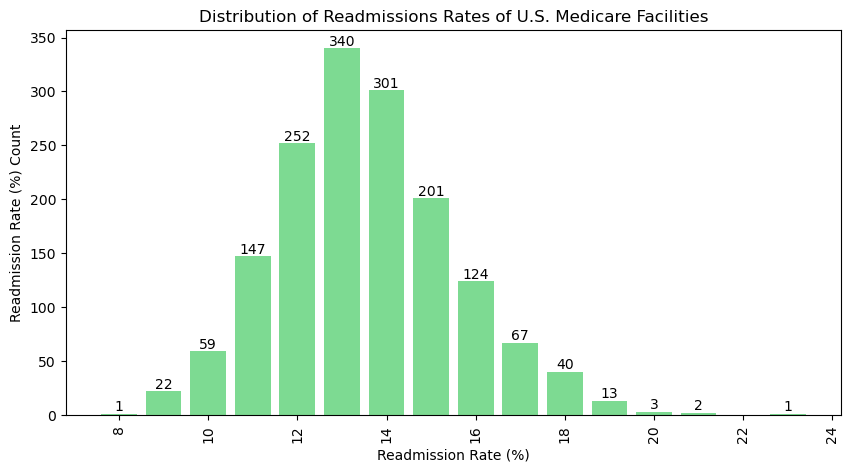

In [86]:
num_read ="Readmission Rate"
rfn = "readmissions_floor_num"

grouped_rrp = full_table.group_by("Facility ID").agg(
    pl.col(num_read).cast(pl.Float64).sum().round().alias(num_read)
)

df_binned = (
    grouped_rrp
    .with_columns(
        pl.col(num_read).cast(pl.Int64)
    )
    .with_columns(
        (pl.col(num_read) // 1 * 1)
            .alias(rfn)
    )
    .with_columns(
        (
            pl.col(rfn).cast(pl.Utf8)
            + "-"
            + (pl.col(rfn)).cast(pl.Utf8)
        ).alias("readmissions_floor")
    )
)

grouped_rrp.head()
create_distribution(grouped_rrp, 
                    num_read, 
                    "Readmission Rate (%)", 
                    True, 
                    num_read,
                    True,
                    "Distribution of Readmissions Rates of U.S. Medicare Facilities",
                    90, 
                    bar_color="#7dda92"
                )


Get distribution of the Number of Hosiptals in each state:

/var/folders/d_/hxjmz8y17js99kwby_186kcc0000gn/T/ipykernel_47229/3803205268.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(


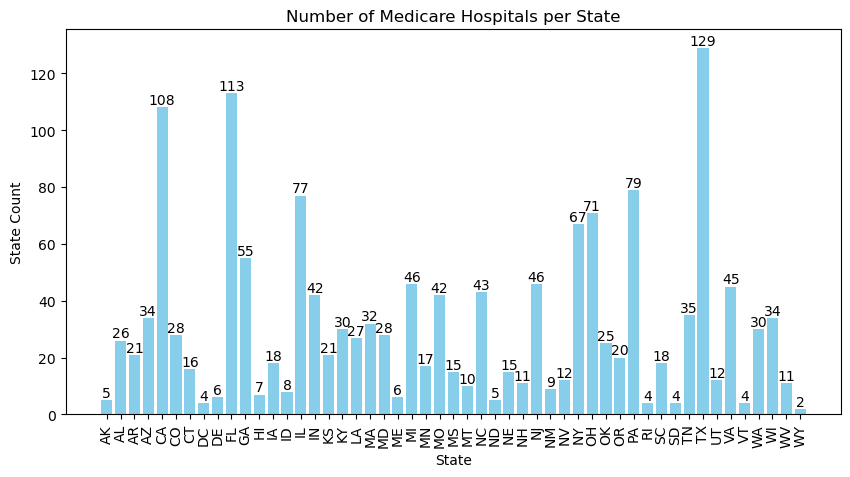

In [87]:
create_distribution(full_table, "State", "State", rotation=90, title_flag=True, title="Number of Medicare Hospitals per State")

Get the Distribution of number of hospitals by ownership type

/var/folders/d_/hxjmz8y17js99kwby_186kcc0000gn/T/ipykernel_47229/3803205268.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(


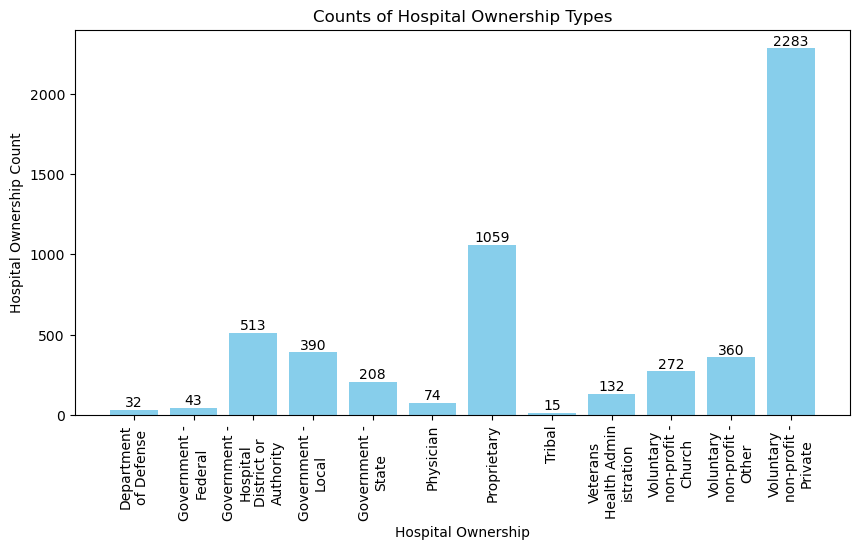

In [88]:
create_distribution(hgi, "Hospital Ownership", "Hospital Ownership", title_flag=True, title="Counts of Hospital Ownership Types", rotation=90)

In [89]:
value = full_table.select(pl.col("Readmission Rate").std()).item()
print(f"The standard deviation of Hospital readmission rates is: {value}")

The standard deviation of Hospital readmission rates is: 1.9856875382580819


In [90]:
# Get the average predicted readmission rate as well as the quartiles
quartile_statistics(full_table, 'Readmission Rate')

shape: (1, 3)
┌─────────────────────┬───────────────────────┬─────────────────────┐
│ Q1 Readmission Rate ┆ Mean Readmission Rate ┆ Q3 Readmission Rate │
│ ---                 ┆ ---                   ┆ ---                 │
│ f64                 ┆ f64                   ┆ f64                 │
╞═════════════════════╪═══════════════════════╪═════════════════════╡
│ 12.1678             ┆ 13.534826             ┆ 14.7012             │
└─────────────────────┴───────────────────────┴─────────────────────┘


#### ANOVA Test #1: Readmission rate & Hospital Ownership
In order to analyze whether a hospital's type, funding type or location affect the readmission rate, I performed an ANOVA test. In this first case, the null hypothesis ($H_0$) was that there is no significant difference in any of the mean readmission rates between different hospital ownership types with an $\alpha$ value of 0.05. The alternative hypothesis ($H_a$) in this case was that there is at least one group mean that is different from the others. As is the case with ANOVA tests, a large F-statistic coupled with a small p-value (< $\alpha$) is enough evidence to reject $H_0$. A large p-value and small F-statistic would not provide enough evidence to reject $H_0$. 

In [91]:
from scipy.stats import f_oneway, f


df = full_table.to_pandas()
grps = [d['Readmission Rate'] for _, d in df.groupby("Hospital Ownership")]
f_statistic, p_value = f_oneway(*grps)

# Calculate the f critical value: 
alpha = 0.05
dfn = 9 # <-- number of groups - 1
dfd = full_table.shape[0] # <-- total number of observations
f_critical = f.ppf(q=1 -alpha, dfn=dfn, dfd=dfd)

# Display the results: 
print(f"The f statistic associated with the ANOVA test is: {round(f_statistic, 4)}")
print(f"The critical F value is {f_critical}")
print(f"The p-value associated with the ANOVA test is: {round(p_value,10)}")

The f statistic associated with the ANOVA test is: 4.3205
The critical F value is 1.885820227809345
The p-value associated with the ANOVA test is: 1.42053e-05


Given that there is an F-statistic larger than the critical F value and the p-value is less than the $\alpha$ value chosen for this test, there is enough evidence to reject $H_0$. This means that not all of the group mean readmission rates are the same. In order to determine which of the 10 group means vary from the others, I will have to follow up with different tests. This will be covered later in the analysis. 

#### ANOVA Test #2: Readmission Rate & Location
I performed a second ANOVA test, this time testing readmission rate differences by location. The null hypothesis ($H_0$) was that there is no significant difference in any of the mean readmission rates between States. Like the first test, the $\alpha$ value is 0.05. The alternative hypothesis ($H_a$) was that there is at least one group mean that is different from the others.

In [92]:
df = full_table.to_pandas()
grps = [d['Readmission Rate'] for _, d in df.groupby("State")]
f_statistic, p_value = f_oneway(*grps)

# Calculate the f critical value: 
alpha = 0.05
dfn = full_table['State'].unique().shape[0] # <-- number of groups - 1
dfd = full_table.shape[0] # <-- total number of observations
f_critical = f.ppf(q=1 -alpha, dfn=dfn, dfd=dfd)


# Display the results: 
print(f"The f statistic associated with the 2nd ANOVA test is: {round(f_statistic, 4)}")
print(f"The critical F value is {f_critical}")
print(f"The p-value associated with the 2nd  ANOVA test is: {p_value}")

The f statistic associated with the 2nd ANOVA test is: 11.1439
The critical F value is 1.354849539029923
The p-value associated with the 2nd  ANOVA test is: 5.531719236699497e-72


Similarly to the first ANOVA test, the 2nd one that is looking at differences in mean readmission rate based on location has enough evidence to reject $H_0$. The p-value is 5.53e<sup>-72</sup>, and the F-statistic, 11.144, is larger than the crifical F value of 1.355 which both support the fact that the $H_0$ should be rejected.

#### Research Question #2:
##### What quality of care metrics, like timeliness, patient experience, and emergency room wait times are most strongly associated with readmission rate?

In order to investigate this question, performed a correlation analysis between the quality of care metrics and the readmissions rates for each hospital. Before completing the correlation analysis, I had to do some data processing. First, I updated encoded the ordinal field EDV (Emergency Department Volume) as an integer. Next, I dropped other categorical variables that could not be converted to a numerical representation. Finally, I completed the correlation analysis and produced a heatmap of the results. 


Updated Correlations with ED Volume:


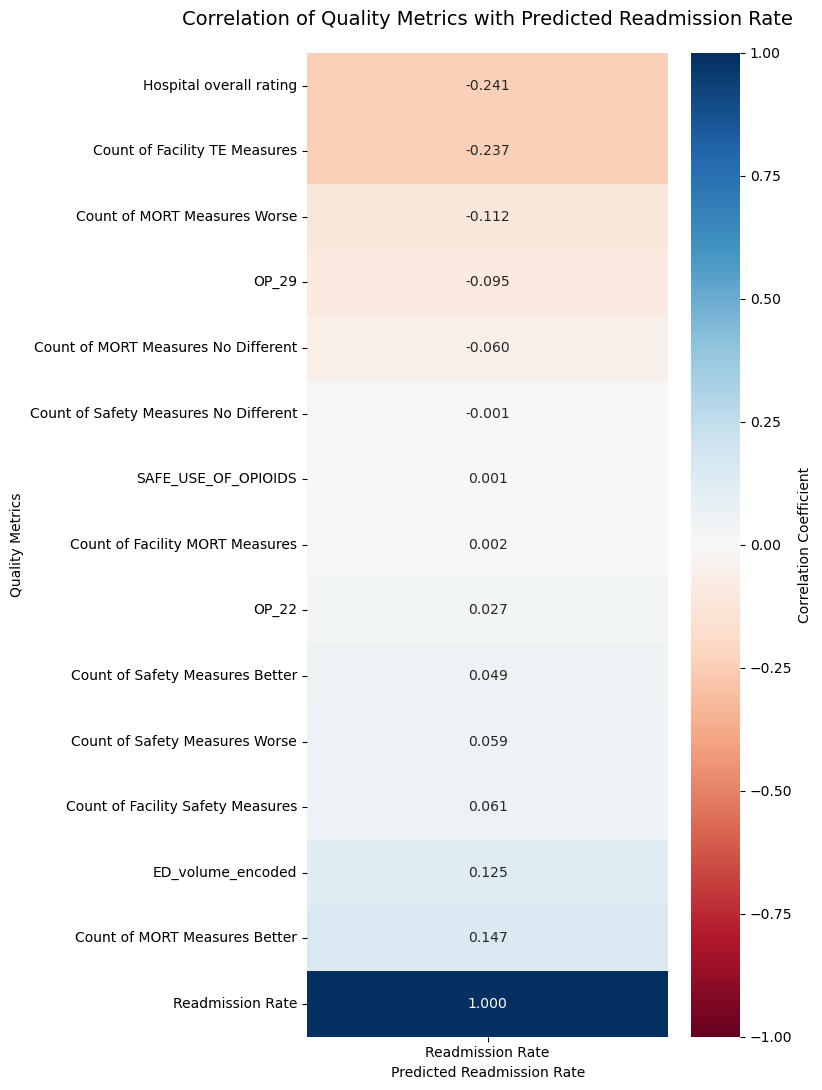

In [93]:
# Update the filtered data to include ED volume encoding
rrp_ha_tec_filtered_with_ed = full_table.with_columns(
    pl.when(pl.col("EDV") == "low")
    .then(1)
    .when(pl.col("EDV") == "medium")
    .then(2)
    .when(pl.col("EDV") == "high")
    .then(3)
    .when(pl.col("EDV")=="very high")
    .then(4)
    .otherwise(None)
    .cast(pl.Float64)
    .alias("ED_volume_encoded")
)

# Calculate correlation matrix with ED volume
corr_mat_with_ed = rrp_ha_tec_filtered_with_ed.drop(["Facility Name","EDV","Facility ID", "State", "Hospital Ownership", "Emergency Services", "Meets criteria for birthing friendly designation"]).to_pandas().corr()

# Display the updated correlations
corr_series_with_ed = corr_mat_with_ed['Readmission Rate'].sort_values()
print("\nUpdated Correlations with ED Volume:")
# print(corr_series_with_ed)

# Create updated heatmap
plt.figure(figsize=(8, 11))
corr_vertical_with_ed = pd.DataFrame(corr_series_with_ed)
sns.heatmap(corr_vertical_with_ed, annot=True, fmt='.3f', cmap='RdBu', center=0,
            cbar_kws={'label': 'Correlation Coefficient'},
            vmin=-1, vmax=1)
plt.title('Correlation of Quality Metrics with Predicted Readmission Rate', fontsize=14, pad=20)
plt.xlabel('Predicted Readmission Rate')
plt.ylabel('Quality Metrics')
plt.tight_layout()
plt.show()



Most of the features in this dataset have a very low correlation with readmission rate. 8 of the metrics have an absolute correlation coefficient that is less than 0.1. This was surprising as I would guess that a hosiptal's safe use of opioids, safety measures, and mortaility measure count would all have a strong association with readmission rate. However, the hospital overall rating, and count of facility timely and effectie care measures have the highest correlation with readmission rate. 

### LASSO Regression for Feature Selection
In order to identify which quality of care metrics are most important for predicting readmission rates, I performed a LASSO (Least Absolute Shrinkage and Selection Operator) regression analysis. LASSO adds a penalty term to the regression that can shrink coefficients to exactly zero, effectively performing feature selection. This identified which variables have the strongest predictive power for readmission rates. I am then able to use this feature subset to more efficiently train other types of models.  

I changed all categorical variables to be indicator variables so they could be preserved throughout the LASSO analysis.
I then split the data to an 80/20 train/test split and used a standard scalar which is a necessary step before training a LASSO model. After all identifier columns were removed, we were left with 27 features to train on. The resulting sizes of the test and train sets are: 
| Dataset | Rows | Columns |
| :------ | :--- | :--- |
| Train | 1258 | 27 |
| Test | 315 | 27 | 

With this context in mind, I then fit a 5-fold LASSO cross validation with `max_iter` = 10,000 and `n_alphas`=100. The resulting test and train metrics are contained below: 
| Metric | Training Set | Test Set |
|--------|--------------|-----------|
| **Mean Absolute Error (MAE)** | 1.3297 | 1.3519 |
| **Mean Squared Error (MSE)** | 2.8970 | 2.9712 |
| **R² Score** | 0.2695 | 0.2261 |

The MSE and MAE values are relatively large considering the average readmission rate is ~13.5 and the standard deviation is 1.98. Similarly, the R^2 value is usually a very informative metric for model evaluation because it represents the percentage of variation in the outcome variable that is due to the predictors. This means that only 22% of the variation in Readmission rate is explained by the LASSO model that was fit. This model is explored more below.

In [94]:
# Prepare data for LASSO
# First, identify columns to exclude (identifiers, dates, categorical text)
identifier_cols = ['Facility ID', 'Facility Name']

# Categorical columns that need encoding
categorical_cols = ['Hospital Ownership', 'EDV']

# Get all columns in filtered table
available_cols = full_table.columns

# Filter identifier columns to only those present in the filtered table
identifier_cols_present = [col for col in identifier_cols if col in available_cols]

print(f"Columns in full_table_filtered: {len(available_cols)}")
print(f"Identifier columns to exclude: {len(identifier_cols_present)}")
print(f"\nIdentifier columns: {identifier_cols_present}")

Columns in full_table_filtered: 21
Identifier columns to exclude: 2

Identifier columns: ['Facility ID', 'Facility Name']


In [95]:
# Encode categorical variables and prepare features
lasso_data_filtered = full_table
# Create mapping of EDV Column: 
EDV_mapping = {'low':0,'medium':1,'high':2,'very high':3}
# Map birthing criteria column: 
BC_mapping = {"Y":1, "N":0}
# Emergency Services Mapping: 
ES_mapping = {"Yes":1, "No":0}

full_table=full_table.with_columns(
    pl.col("EDV")
      .replace_strict(EDV_mapping, default="Unknown")
      .alias("EDV_encoded")
      .cast(pl.Int64),
    pl.col("Meets criteria for birthing friendly designation")
      .replace_strict(BC_mapping, default="Unknown")
      .alias("meet_birthing_friendly_designation_criteria_encoded")
      .cast(pl.Int64),
    pl.col("Emergency Services")
      .replace_strict(ES_mapping, default="Unknown")
      .alias("emergency_services_encoded").cast(pl.Int64)
)

# One-hot encode Hospital Ownership
if "Hospital Ownership" in available_cols:
    ownership_types = full_table["Hospital Ownership"].unique().to_list()
    ownership_types = [ot for ot in ownership_types if ot is not None and ot.lower() != "not available"]
    print(f"Hospital Ownership Types: {ownership_types}")
    
    for ownership_type in ownership_types:
        lasso_data_filtered = lasso_data_filtered.with_columns(
            pl.when(pl.col("Hospital Ownership") == ownership_type)
            .then(1)
            .otherwise(0)
            .alias(f"Ownership_{ownership_type.replace(' ', '_').replace('/', '_').replace('-', '_')}")
        )

print(f"\nShape after encoding: {lasso_data_filtered.shape}")

Hospital Ownership Types: ['Government - Federal', 'Proprietary', 'Physician', 'Government - Hospital District or Authority', 'Tribal', 'Voluntary non-profit - Other', 'Voluntary non-profit - Church', 'Government - Local', 'Voluntary non-profit - Private', 'Government - State']

Shape after encoding: (1573, 31)


In [96]:
# Select features for LASSO - exclude identifiers and original categorical columns
exclude_for_lasso = identifier_cols_present + ['Hospital Ownership', 'State', 'Meets criteria for birthing friendly designation',
                                                 'Emergency Services', 'EDV', 'Readmission Rate']

# Get all numeric and encoded columns
feature_cols = [col for col in lasso_data_filtered.columns if col not in exclude_for_lasso]

print(f"Number of features for LASSO: {len(feature_cols)}")

# Prepare X (features) and y (target)
X_lasso = lasso_data_filtered.select(feature_cols).to_pandas()
y_lasso = lasso_data_filtered.select('Readmission Rate').to_pandas()['Readmission Rate']


Number of features for LASSO: 23


In [97]:
# Remove rows where target variable is null
valid_indices = y_lasso.notna()
X_lasso_clean = X_lasso[valid_indices]
y_lasso_clean = y_lasso[valid_indices]

In [98]:
# Split data into train and test sets
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(
    X_lasso_clean, y_lasso_clean, test_size=0.2, random_state=25
)

print(f"\nTraining set: {X_train_lasso.shape}")
print(f"Test set: {X_test_lasso.shape}")

# Standardize features (required for LASSO)
scaler = StandardScaler()
X_train_scaled_lasso = scaler.fit_transform(X_train_lasso)
X_test_scaled_lasso = scaler.transform(X_test_lasso)
print(f"  Training set shape: {X_train_scaled_lasso.shape}")
print(f"  Test set shape: {X_test_scaled_lasso.shape}")

print("\n Data prepared for LASSO regression")
print(f"Final feature count: {X_train_scaled_lasso.shape[1]}")


Training set: (1258, 23)
Test set: (315, 23)
  Training set shape: (1258, 23)
  Test set shape: (315, 23)

 Data prepared for LASSO regression
Final feature count: 23


In [99]:
# Train LASSO with cross-validation
print("Training LassoCV model...  ")
lasso_cv_full = LassoCV(cv=5, random_state=25, max_iter=10000, n_alphas=100)
lasso_cv_full.fit(X_train_scaled_lasso, y_train_lasso)

print(f"Optimal alpha: {lasso_cv_full.alpha_:.6f}")
print(f"Number of features selected: {np.sum(lasso_cv_full.coef_ != 0)}")
print(f"Number of features eliminated: {np.sum(lasso_cv_full.coef_ == 0)}")

# Make predictions
y_train_pred_lasso = lasso_cv_full.predict(X_train_scaled_lasso)
y_test_pred_lasso = lasso_cv_full.predict(X_test_scaled_lasso)

# Evaluate model
evaluate_model(y_train_lasso, y_train_pred_lasso, y_test_lasso, y_test_pred_lasso)


Training LassoCV model...  
Optimal alpha: 0.024850
Number of features selected: 13
Number of features eliminated: 10
TRAINING SET METRICS: 
Train Mean Abs Error: 1.3919
Train Mean Squared Error: 3.2019
Train R^2: 0.1926
TEST SET METRICS: 
Test Mean Squared Error: 3.1934
Test Random Forest Regressor Mean Abs Error: 1.3974
Test Random Forest Regressor R^2: 0.1682


/opt/anaconda3/envs/data512/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


In [105]:
# Extract feature importance (coefficients)
# Note: X_lasso_clean may have had columns removed if they were all-null
# The final feature names are those that made it through to training
final_feature_names = X_lasso_clean.columns.tolist()

feature_importance = pd.DataFrame({
    'Feature': final_feature_names,
    'Coefficient': lasso_cv_full.coef_
})

# Separate selected and eliminated features
selected_features = feature_importance[feature_importance['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=False)
eliminated_features = feature_importance[feature_importance['Coefficient'] == 0]


Next, I created a feature importance visual to examine which features of the dataset are most important when it comes to explaining a hospital's readmission rate according to the LASSO analysis. The LASSO model ended up with 13 relevant features from the original 23 which I have displayed below. 

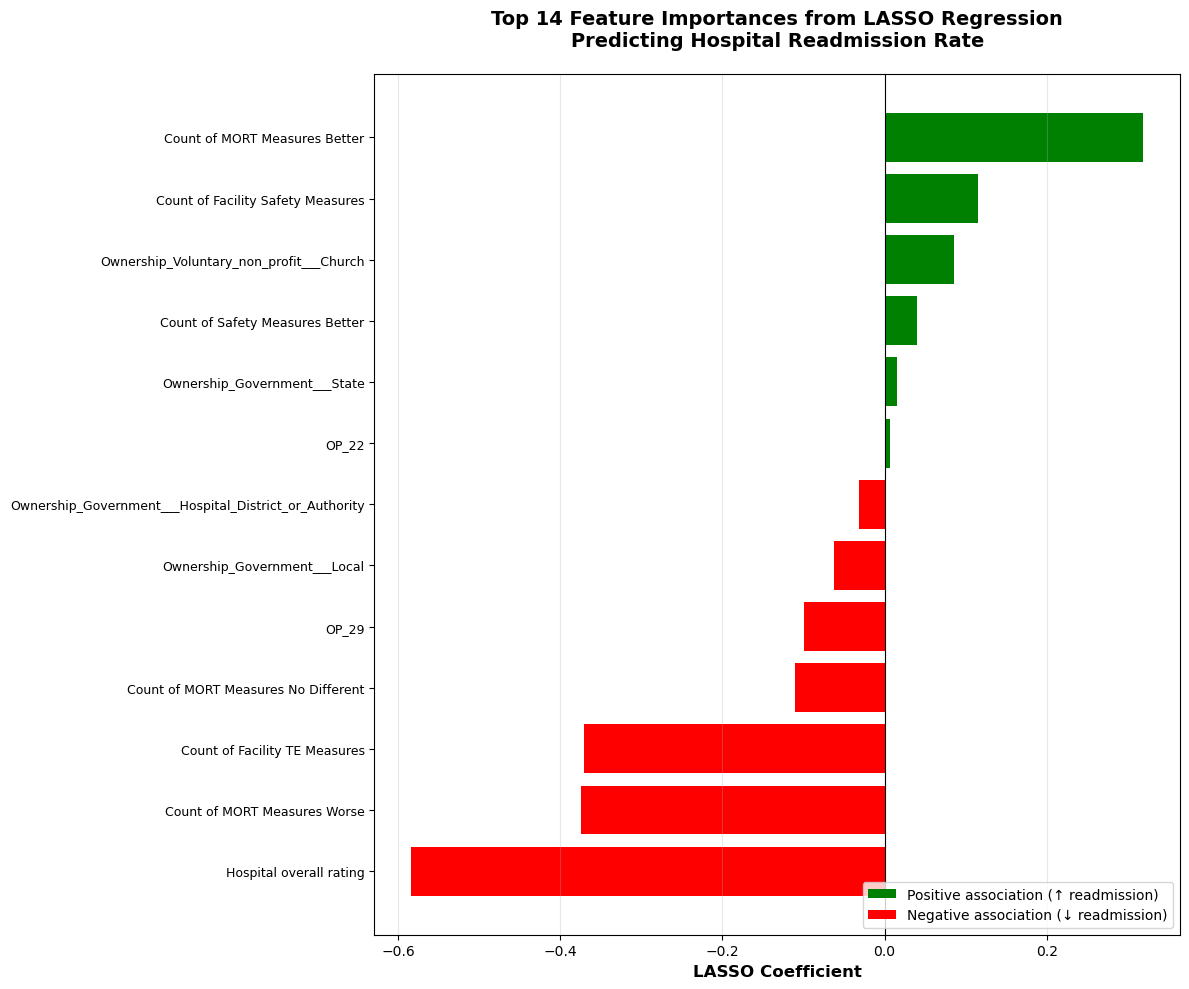

In [ ]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 10))

# Get top 25 features by absolute coefficient value
top_features = selected_features.head(15).sort_values('Coefficient')

# Create color map (positive = green, negative = red)
colors_bar = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]

# Create horizontal bar chart
bars = ax.barh(range(len(top_features)), top_features['Coefficient'], color=colors_bar)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'], fontsize=9)
ax.set_xlabel('LASSO Coefficient', fontsize=12, fontweight='bold')
ax.set_title('Top 13 Feature Importances from LASSO Regression\nPredicting Hospital Readmission Rate', 
             fontsize=14, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', label='Positive association (↑ readmission)'),
                   Patch(facecolor='red', label='Negative association (↓ readmission)')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

This feature importance graph shows the top 15 most important features in the dataset for predicting readmission rate along with their respective association with readmission rate. Any variables marked with a green bar have a positive LASSO coefficient indicating a positive association- as the variable value increases, so does readmission rate. A variable with a red bar has a negative LASSO coefficient which indicates a negative association.  

There are some interesting insights that can be gained from this graph. There are some intuitive findings like how a higher hospital rating indicates a decrease in readmission. And as the `COUNT of TE Measures` variable increases, readmission rate decreases. This makes sense as this variable represents the number of Timely and effective care measures used in the hospital’s overall star rating. The [star rating](https://data.cms.gov/provider-data/topics/hospitals/overall-hospital-quality-star-rating/) system was desinged by the government to rate each Medicare Hospital and plan. It has reimbursement and funding implications. Therefore it makes logical sense that if there are more meausres that rate timely and effective care in their rating, the hospital would try and perform well on them to secure a higher star rating. 

There are also some unexpected coefficient values. For example, `Count of Mort Measures Better`, which represents the number of Mortality measures that are better than the national value for a specific facility, has a positive association with readmission rate. So as the number of measure average mortality measures that are outperforming the national average would indicate a higher readmission rate. This is at unexpected, and confusing at first glance- why would a hospital that is outpeforming the national average at mortality prevention measures have a higher readmission rate? It may be that a hospital with a better mortality rating is able to keep sicker patients alive that might have died at a different hospital. Plainly, more patients' lives that are saved means there are more patients that could be readmitted. 

This is similar to the results from the correlation analysis. The hosiptal's overall rating and number of facility's timely and effective care measures used to rate the hospital have a large association with readmission rate. 

#### Linear Regression

Next, I fit a linear regression model on the data to try and predict a hospital's readmission rate. I carried over the selected features that were found from the LASSO analysis above. This is because they should be the most informative features from the dataset when trying to predict readmission rate. I applied a standard linear regression model to estimate the relationship between hospital characteristics and overall readmission rate. Linear regression assumes a linear relationship between predictors and the outcome and serves as a useful baseline model for comparison because it is simple and interpretable.  

After training on the scaled dataset and evaluating on the test set, the model achieved an R² of 0.1621 and MSE of 3.217. The model captures some of the variation of readmission rate, but most of it is still unexplained. This could be that there is a nonlinear relationship between hospital factors and readmission rate. Or there could be factors not present in the data set that influence readmission rate.  

In [104]:
selected_columns = selected_features['Feature'].tolist()
X = X_lasso_clean[selected_columns]

y_reg = y_lasso_clean

# Split data into training and testing sets
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=25)

model = LinearRegression()
model.fit(X_train, y_train_reg)

# 4. Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

# 5. Evaluate the model
linear_mae = mean_absolute_error(y_test_reg, y_pred)
linear_rsquared = r2_score(y_test_reg, y_pred)
print(f"Mean Abs error: {linear_mae:.3f}")
print(f"R^2: {linear_rsquared:.3f}")
evaluate_model (y_train_reg, y_pred_train, y_test_reg, y_pred)

Mean Abs error: 1.401
R^2: 0.162
TRAINING SET METRICS: 
Train Mean Abs Error: 1.3895
Train Mean Squared Error: 3.192
Train R^2: 0.1951
TEST SET METRICS: 
Test Mean Squared Error: 3.2168
Test Random Forest Regressor Mean Abs Error: 1.4014
Test Random Forest Regressor R^2: 0.1621


#### Random Forest
Next, I decided to fit a random forest model. It is a type of ensemble model that involves creating a lot of decision trees and then average the predictions to try and increase accuracy and guard against overfitting. Random forests can model nonlinear relationships and patters, so this was the next logical step in determining the interaction between hospital features and readmission. It also makes sense to try a method that handles nonlinearity because a health data and health system data is highly complex.  
I chose Random forest instead of polynomial regression or splines because it is also very interpretable.  

I performed a grid search hyperparameter tuning on the number of estimators (number of trees), max depth, max features, min samples per split, and min samples per leaf before fitting the final model. 

The final suite of parameters chosen was: 
* max_depth=10 
* max_features='sqrt'
* min_samples_leaf=2
* min_samples_split=2
* n_estimators=200

The model produced a test-set R^2 of 0.197 and an MAE of 1.37. These are similar results to the linear regression baseline model and had marginally better predictive power. Given that there wasn't a large increase in prediction power there is most likely some nonlinearity that exists in this data but the features in my dataset do not capture enough info about readmission rates. 

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 500, 800],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train_reg)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print(best_params, best_estimator)


# # Create a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=best_params['n_estimators'], random_state=25, min_samples_leaf=best_params['min_samples_leaf'], min_samples_split=best_params['min_samples_split'], max_depth=best_params['max_depth'], max_features=best_params['max_features'])

# # Train the model
rf_regressor.fit(X_train, y_train_reg)

{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200} RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=200, random_state=42)


,n_estimators,200
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Make predictions on the test set
y_pred_reg = rf_regressor.predict(X_test)
y_pred_train_reg = rf_regressor.predict(X_train)

evaluate_model (y_train_reg, y_pred_train_reg, y_test_reg, y_pred_reg)

TRAINING SET METRICS: 
Train Mean Abs Error: 1.0706
Train Mean Squared Error: 1.8724
Train R^2: 0.5278
TEST SET METRICS: 
Test Mean Squared Error: 3.0826
Test Random Forest Regressor Mean Abs Error: 1.3724
Test Random Forest Regressor R^2: 0.1971


# Discussion



| Model | Test MAE | Train MAE | Test MSE | Train MSE| Test R^2 | Train R^2 |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| LASSO | 1.397 | 1.3919 | 3.1934 | 3.2019 | 0.1682 | 0.1926 | 
| Linear Regression | 1.4014 | 1.3895 | 3.217 | 3.192 | 0.1621 | 0.1951| 
| Random Forest | 1.3724 | 1.0706 | 3.0826 | 1.8724 | 0.1971 | 0.5278 | 
 

# Conclusion

